# Learning Curve Example with a Pipeline

This is an example of a learning curve based on a Pytorch model that is part of a Scikit Learn pipeline.  The model is taken from the Skorch "Quickstart" documentation (see https://skorch.readthedocs.io/en/stable/user/quickstart.html).

In [ ]:
!pip list

In [2]:
# Packages to install on Google Colab
!pip install --upgrade skorch scikit-learn # need scikit-learn v1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import LearningCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, make_scorer
import torch
import torch.nn as nn
from skorch import NeuralNetClassifier

In [4]:
# Same model used in Skorch documentation
X, y = make_classification(2000, 20, n_informative=10, random_state=0)
X = X.astype(np.float32)
y = y.astype(np.int64)

class MyModule(nn.Module):
    def __init__(self, num_units=10, nonlin=nn.ReLU()):
        super().__init__()

        self.dense0 = nn.Linear(20, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(num_units, num_units)
        self.output = nn.Linear(num_units, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = self.nonlin(self.dense1(X))
        X = self.output(X)
        return X

net = NeuralNetClassifier(
    MyModule,
    max_epochs=10,
    criterion=nn.CrossEntropyLoss(),
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [5]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('net', net),
])

In the learning curves below, the training and testing accuracy gradually reach similar values towards the right of the plot.  This suggests the model does not suffer from high variance.

Since both lines have not leveled out towards the right of the plot, more data may help improve performance.  In fact, testing accuracy around 70% can be achieved with 2000 data points.

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9188       0.0000        0.8105  0.0258
      2        0.8188       0.5000        0.7197  0.0063
      3        0.7144       1.0000        0.6380  0.0044
      4        0.6402       1.0000        0.5688  0.0031
      5        0.5400       1.0000        0.5088  0.0048
      6        0.4892       1.0000        0.4560  0.0038
      7        0.4289       1.0000        0.4090  0.0030
      8        0.4027       1.0000        0.3678  0.0038
      9        0.3357       1.0000        0.3318  0.0032
     10        0.3195       1.0000        0.3009  0.0036
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6209       0.8750        0.5586  0.0030
      2        0.6033       0.8750        0.5410  0.0070
      3        0.6012       0.8750        0.5251  0.0034
      4        0.5772       0.8

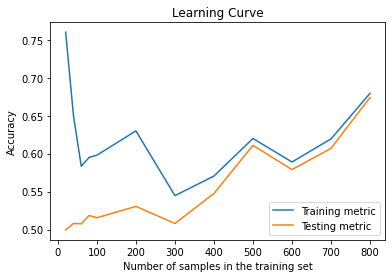

In [6]:
# Note: exploit_incremental_learning cannot be set equal to True
#   since pipe does not have a "partial_fit" method
lcd = LearningCurveDisplay.from_estimator(
    pipe, X, y, score_type='both', score_name='Accuracy', 
    scoring=make_scorer(accuracy_score), 
    std_display_style=None,
    train_sizes=np.concatenate((np.arange(20,100,20),
                               np.arange(100,900,100))))
lcd.ax_.set_title('Learning Curve')
lcd.ax_.legend(loc='lower right');